In [1]:
%pylab inline
import pandas as pd
import gc
import fastparquet

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../third/LightGBM/python-package/build/lib/')
import lightgbm as lgb
lgb.__version__,lgb.__file__

('2.0.5', '../third/LightGBM/python-package/build/lib/lightgbm/__init__.pyc')

In [3]:
%time train1 = fastparquet.ParquetFile('../input/newtrain_cat2way_be.parq').to_pandas()

CPU times: user 12.1 s, sys: 1.78 s, total: 13.8 s
Wall time: 20.4 s


In [4]:
%time train2 = fastparquet.ParquetFile('../input/newtrain_cat2way_be_rnd.parq').to_pandas()

CPU times: user 9.16 s, sys: 1.37 s, total: 10.5 s
Wall time: 13.1 s


In [5]:
train=pd.concat([train1.drop('target',axis=1),train2],axis=1)

In [6]:
columns=train.columns

In [7]:
target=train1['target']

In [8]:
del train1
del train2
gc.collect()

1727

In [9]:
train.shape

(595212, 3422)

In [10]:
X=train.values
y=target.values

In [11]:
X.shape,y.shape

((595212, 3422), (595212,))

In [12]:
d_train = lgb.Dataset(X, label=y)

In [13]:
import random

params = {
    'task': 'train',
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 63,
    'feature_fraction_seed': random.randint(2,12345),
    'bagging_seed': random.randint(2,12345),

    #'learning_rate': 0.05,
    'feature_fraction': np.sqrt(X.shape[1])/X.shape[1],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    "num_threads":24,
    'verbose': 1,
}

In [14]:
def run_once():
    params['feature_fraction_seed'] = random.randint(2,12345)
    params['bagging_seed'] =  random.randint(2,12345),
    print params
    gbm = lgb.train(params, \
                d_train, \
                num_boost_round=500)    
    return gbm.feature_importance()

In [10]:
import cPickle as pickle 

In [16]:
fi=[]

In [17]:
fi=pickle.load(open('fi.pkl'))

In [18]:
for i in range(3):
    print i,
    %time fi.append(run_once())
    pickle.dump(fi,open("fi.pkl",'wb'))

0 {'num_leaves': 63, 'verbose': 1, 'bagging_seed': (7058,), 'metric': set(['binary_logloss']), 'bagging_freq': 5, 'boosting_type': 'rf', 'feature_fraction_seed': 2420, 'num_threads': 24, 'task': 'train', 'bagging_fraction': 0.8, 'objective': 'binary', 'feature_fraction': 0.017094641498783945}
CPU times: user 2h 11min 56s, sys: 3min 14s, total: 2h 15min 11s
Wall time: 6min 49s
1 {'num_leaves': 63, 'verbose': 1, 'bagging_seed': (2654,), 'metric': set(['binary_logloss']), 'bagging_freq': 5, 'boosting_type': 'rf', 'feature_fraction_seed': 2425, 'num_threads': 24, 'task': 'train', 'bagging_fraction': 0.8, 'max_bin': 255, 'objective': 'binary', 'feature_fraction': 0.017094641498783945}
CPU times: user 2h 6min 32s, sys: 2min 32s, total: 2h 9min 4s
Wall time: 5min 22s
2 {'num_leaves': 63, 'verbose': 1, 'bagging_seed': (2709,), 'metric': set(['binary_logloss']), 'bagging_freq': 5, 'boosting_type': 'rf', 'feature_fraction_seed': 3861, 'num_threads': 24, 'task': 'train', 'bagging_fraction': 0.8, 

In [19]:
len(fi)

30

In [11]:
fi=pickle.load(open('fi.pkl'))

In [12]:
len(fi)

30

In [13]:
fidf=pd.DataFrame(fi).T

In [25]:
fidf.index=columns

In [26]:
fidf_rnd=fidf.iloc[len(fidf)/2:]

In [27]:
fidf_feats=fidf.iloc[:len(fidf)/2]

In [28]:
fidf.shape,fidf_rnd.shape

((3422, 30), (1711, 30))

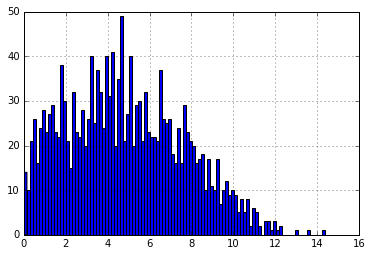

In [58]:
fidf_rnd.mean(1).hist(bins=100);

In [141]:
rnd_max=fidf_rnd.max(axis=0)

In [79]:
rnd_mean=fidf_rnd.mean(axis=1)

In [113]:
np.where(rnd_mean==rnd_mean.max())

(array([673]),)

In [97]:
max_mean=rnd_mean.max()

In [151]:
max_mean=rnd_max.mean()

In [152]:
test_mean(b,max_mean)

5.9325707271326029e-31

In [153]:
import scipy.stats

In [154]:
def test_mean(a,amean):
    s=np.std(a)
    n=len(a)
    t=(a.mean()-amean)/s*n
    return scipy.stats.t.sf(t,df=n-1)

In [190]:
max_mean=rnd_mean.max()
max_mean

14.366666666666667

In [191]:
pvals=fidf_rnd.apply(lambda u: test_mean(u.values,max_mean),axis=1)

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


In [192]:
pvals.min(),pvals.max()

(0.5, 1.0)

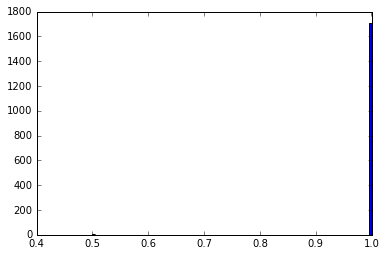

In [193]:
plt.hist(pvals,bins=100);

In [194]:
pvals=fidf_feats.apply(lambda u: test_mean(u.values,max_mean),axis=1)

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


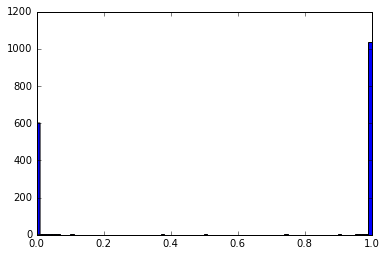

In [195]:
plt.hist(pvals,bins=100);

In [196]:
(pvals<0.05).sum()

616

In [197]:
pvals1=pvals
pvals1.name="t-test:rnd-mean1-max"

In [198]:
max_mean=rnd_max.mean()
max_mean

25.066666666666666

In [199]:
pvals=fidf_rnd.apply(lambda u: test_mean(u.values,max_mean),axis=1)

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


In [200]:
pvals.min(),pvals.max()

(1.0, 1.0)

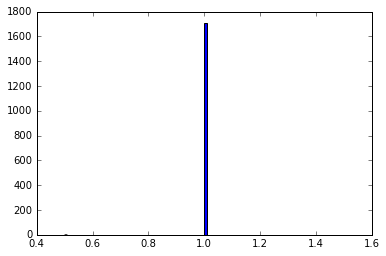

In [201]:
plt.hist(pvals,bins=100);

In [202]:
pvals=fidf_feats.apply(lambda u: test_mean(u.values,max_mean),axis=1)

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


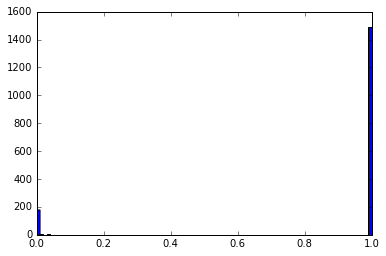

In [203]:
plt.hist(pvals,bins=100);

In [204]:
(pvals<0.05).sum()

187

In [205]:
pvals2=pvals
pvals2.name="t-test:rnd-max0-mean"

In [206]:
from scipy.stats import ranksums,mannwhitneyu

In [207]:
mannwhitneyu(fidf_feats.iloc[0],rnd_max,alternative="greater")

MannwhitneyuResult(statistic=0.0, pvalue=0.99999999998786848)

In [208]:
mannwhitneyu(fidf_feats.max(0),rnd_max,alternative="greater")

MannwhitneyuResult(statistic=900.0, pvalue=1.3957504797227155e-11)

In [210]:
ranks=fidf_rnd.apply(lambda u: mannwhitneyu(u,rnd_max,alternative="greater")[1],axis=1)

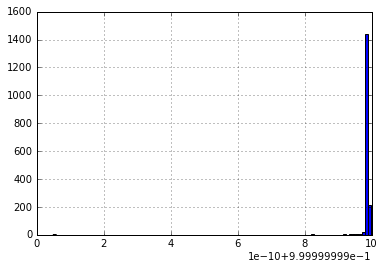

In [211]:
ranks.hist(bins=100);

In [212]:
ranks.max(),ranks.min()

(0.99999999999950318, 0.99999999904918091)

In [213]:
ranks=fidf_feats.apply(lambda u: mannwhitneyu(u,rnd_max,alternative="greater")[1],axis=1)

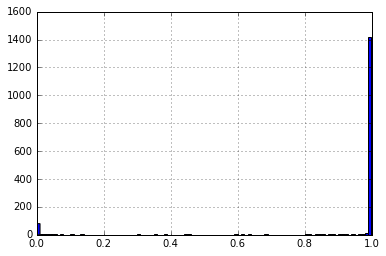

In [214]:
ranks.hist(bins=100);

In [215]:
(ranks<0.05).sum()

108

In [216]:
ranks.name='mannwhitneyu:rnd_max0'

In [220]:
df=pd.concat([ranks,pvals1,pvals2],axis=1)

In [222]:
df.to_csv("2way_feature_test.csv")

In [227]:
df.head()

mannwhitneyu:rnd_max0  t-test:rnd-mean1-max  \
ps_calc_01*ps_calc_02                    1.0                   1.0   
ps_calc_01*ps_calc_03                    1.0                   1.0   
ps_calc_01*ps_calc_04                    1.0                   1.0   
ps_calc_01*ps_calc_05                    1.0                   1.0   
ps_calc_01*ps_calc_06                    1.0                   1.0   

                       t-test:rnd-max0-mean  
ps_calc_01*ps_calc_02                   1.0  
ps_calc_01*ps_calc_03                   1.0  
ps_calc_01*ps_calc_04                   1.0  
ps_calc_01*ps_calc_05                   1.0  
ps_calc_01*ps_calc_06                   1.0

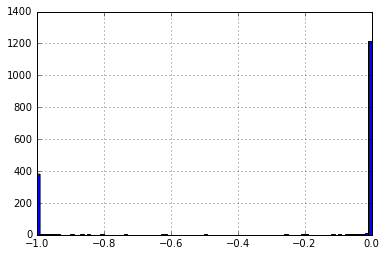

In [228]:
(df[df.columns[1]]-df[df.columns[2]]).hist(bins=100)

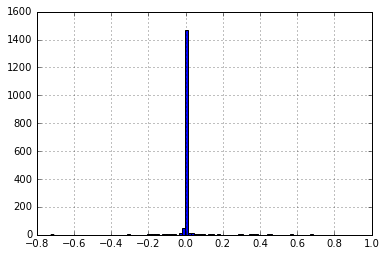

In [237]:
(df[df.columns[0]]-df[df.columns[2]]).hist(bins=100)

In [234]:
a=df[df[df.columns[0]]<0.05].index
len(a)

108

In [250]:
b=df[df[df.columns[2]]<0.05].index
len(b)

187

In [239]:
len(a.intersection(b))

108

In [240]:
len(a.difference(b))

0

In [241]:
len(b.difference(a))

79

In [243]:
c=df[df[df.columns[1]]<0.05].index
len(c)

616

In [254]:
x=set(reduce(lambda u,v: u+v, fidf_feats.index.map(lambda u: u.split("*"))))

In [255]:
len(x)

59

In [272]:
y= b.map(lambda u: (u.split("*")))
len(y)

187

In [273]:
y[0]

['ps_calc_01', 'ps_ind_03']

In [287]:
z=[]
for c in x:
    for s  in y:
        s=set(s)
        s.update([c])
        if len(s)<3: continue
        z.append( ",".join(s) )
len(z)

10659

In [288]:
z=list(set(z))
len(z)

8669

In [289]:
z[0]

'ps_car_09_cat,ps_reg_02,ps_car_05_cat'